# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)


In [1]:
import tensorflow as tf
from tensorflow.train import AdamOptimizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorboardcolab import *

Using TensorFlow backend.


In [0]:
import numpy as np
import random
from collections import Counter

unknown_token = "UNK"

class SkipGramBatcher:
    def __init__(self, window_size=5, least_freq=3):
        self.least_freq = least_freq
        self.text = None
        self.vocab = None
        self.vocab_size = None
        self.word2index = None
        self.index2word = None
        self.window_size = window_size
        self.current_index = 0
        self.current_diff = -window_size
        self.total_size = 0
    
    def preprocess(self, text):
        """replace words with frequency < least_freq with unknown_token
        and save the text
        """
        counter = Counter(text)
        def get_token(word):
            if counter[word] < self.least_freq:
                return unknown_token
            else:
                return word.lower()
        self.text = [get_token(word) for word in text]
    
    def fit_text(self, text):
        """init text, vocab, word2ind, ind2word
        """
        self.preprocess(text)
        self.vocab = np.unique(self.text)
        self.vocab_size = self.vocab.shape[0]
        self.word2index = dict(zip(self.vocab, range(self.vocab.shape[0])))
        self.index2word = dict(zip(range(self.vocab.shape[0]), self.vocab))
        self.total_size = (len(self.text) - 3 * self.window_size) * self.window_size * 2
        
    def most_frequent(self, num=25):
        counter = Counter(self.text)
        return counter.most_common(num)
        
    def least_frequent(self, num=25):
        counter = Counter(self.text)
        return counter.most_common()[:-num - 1:-1]
        
    def indices_to_words(self, x_batch):
        return np.array([self.index2word[index] for index in x_batch])
    
    def words_to_indices(self, words):
        return np.array([self.word2index[word] for word in words])
    
    def get_next_index_and_diff(self, current_index, current_diff):
        if (current_diff == self.window_size):
            current_diff = -self.window_size
            current_index += 1
            current_index %= len(self.text)
        else:
            if current_diff == -1:
                current_diff = 1
            else:
                current_diff += 1
        return current_index, current_diff

    
    def get_batch(self, batch_size=100):
        x_batch = []
        labels_batch = []
        while len(x_batch) < batch_size:
            label_index_in_text = self.current_index + self.current_diff 
            if (label_index_in_text < 0 or label_index_in_text >= len(self.text)):
                index, diff = self.get_next_index_and_diff(self.current_index, self.current_diff)
                self.current_index = index
                self.current_diff = diff
                continue
                
            word = self.text[self.current_index]
            word_index = self.word2index[word]
            label = self.text[self.current_index + self.current_diff]
            label_index = self.word2index[label]
            
            x_batch.append(word_index)
            labels_batch.append(label_index)
            
            index, diff = self.get_next_index_and_diff(self.current_index, self.current_diff)
            self.current_index = index
            self.current_diff = diff
            
        assert len(x_batch) == batch_size
        assert len(labels_batch) == batch_size
        
        x_batch = np.array(x_batch)
        labels_batch = np.array(labels_batch)
        
        permut = np.random.permutation(range(batch_size))
        x_batch = x_batch[permut]
        labels_batch = labels_batch[permut]
        return x_batch, labels_batch
    
    def batch_generator(self, batch_size=100):
        while True:
            x_batch, labels_batch = self.get_batch(batch_size)
            yield x_batch, labels_batch

In [3]:
!mkdir logs_new
!ls
!wget http://mattmahoney.net/dc/text8.zip

logs_new  sample_data
--2020-02-26 22:34:28--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.07MB/s    in 15s     

2020-02-26 22:34:44 (2.05 MB/s) - ‘text8.zip’ saved [31344016/31344016]



In [4]:
!ls
!unzip text8.zip

logs_new  sample_data  text8.zip
Archive:  text8.zip
  inflating: text8                   


In [5]:
!ls
!ls -l logs_new

logs_new  sample_data  text8  text8.zip
total 0


In [6]:
filename = 'text8' #file with the raw text
text = []
with open('text8', mode='r') as file:
    line = file.readline()
    while line:
        text += line.lower().split(' ')
        line = file.readline()
        if len(text) > 100000:
            print(len(text))
            break

17005208


In [0]:
batcher = SkipGramBatcher(window_size=5, least_freq=3)
batcher.fit_text(text[:1000000])

In [8]:
USE_GPU = True
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


In [9]:
from IPython.core.display import HTML

color="255,127,80"  # coral

def print_training_progress(c, text):
    source = "<small><small><h1 style='color: rgb({0})'>{1}</h1></small></small>".format(c, text)
    return HTML(source)

print_training_progress(color, 'test')

In [0]:
def kaiming_normal(shape):
    return tf.random_normal(shape) * np.sqrt(2.0 / shape[0])

In [0]:
save_every = 200
loss_every = 200
summary_every = 50
log_every = 50
USE_TENSORBOARDCOLAB = True

In [0]:
class Word2Vec:
    def __init__(self, vocab_size, embeddings_size):
        tf.reset_default_graph()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        self.vocab_size = vocab_size
        self.embeddings_size = embeddings_size
        
    def close(self):
        tf.reset_default_graph()
        self.sess.close()
        
    def init_weights(self):
        self.w1 = tf.Variable(kaiming_normal((self.vocab_size, self.embeddings_size)), name='w1')
        self.w2 = tf.Variable(kaiming_normal((self.embeddings_size, self.vocab_size)), name='w2')
        
    def model_fn(self, x):
        x = tf.matmul(x, self.w1)
        x = tf.matmul(x, self.w2)
        return x
    
    def get_loss(self, scores, y):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(losses)
        return loss
    
    def train(self, batcher, batch_size=10, epochs=3, learning_rate=0.01):        
        with tf.device(device):
            self.init_weights()
            
            x = tf.placeholder(dtype=tf.int32, shape=(batch_size))
            y = tf.placeholder(dtype=tf.int32, shape=(batch_size))
            
            x_one_hot = tf.one_hot(x, self.vocab_size)
            
            scores = self.model_fn(x_one_hot)
            loss = self.get_loss(scores, y)
            tf.summary.scalar('cross_entropy', loss)
            
            train_op = AdamOptimizer(learning_rate).minimize(loss)
            
            saver = tf.train.Saver({"w1" : self.w1, "w2" : self.w2})
            merged = tf.summary.merge_all()
            
            if USE_TENSORBOARDCOLAB:
                tbc = TensorBoardColab()
                train_writer = tbc.get_writer()
                print()
                print('initialized writer for tensorboard logging...')
                print()
            else:
                train_writer = tf.summary.FileWriter('./tensorboard/train')
            
            #training
            self.sess.run(tf.global_variables_initializer())
            
            min_loss = 1e9
            losses = []
            print('Starting training...')
            try:
                for epoch in range(epochs):
                    iter_count = int(batcher.total_size / batch_size)
                    for step in range(iter_count):
                        x_batch, labels_batch = batcher.get_batch(batch_size)
                        feed_dict = {x : x_batch, y : labels_batch}
                        
                        if step % summary_every == 0:
                            print('writing summary to tensorboard...')
                            print()
                            summary = self.sess.run(merged, feed_dict=feed_dict)
                            train_writer.add_summary(summary, iter_count * epoch + step)
                        
                        np_loss, _ = self.sess.run([loss, train_op], feed_dict=feed_dict)
                        
                        if step % log_every == 0:
                            print('running epoch: {}, step: {}, loss = {}...'.format(epoch, step, np_loss))
                            print()

                        if min_loss > np_loss:
                            saver.save(self.sess, "./logs/model_min_loss.ckpt")
                            print("minimal loss updated from {} to {} | at step {}...".format(min_loss, np_loss, step))
                            min_loss = np_loss
                            print("Model weights and loss saved in ./logs/model_min_loss.ckpt | at step {}...".format(step))
                            print()
                        if step % save_every == 0:
                            saver.save(self.sess, "./logs/model_default_save.ckpt")
                            print("Model with loss = {} saved to ./logs/model_default_save.ckpt | at step {}...".format(np_loss, step))
                            print()
                        if step % loss_every == 0:
                            if len(losses) > 10000000:
                                print('Already a lot losses...')
                            else:
                                losses.append(np_loss)
                                print("Losses saved to ./logs/losses_history... | at step {}".format(step))
                                print()
                                np.save('./logs/losses_history', np.array(losses))
            except KeyboardInterrupt:
                print('KeyboardInterrupt')
    
    def get_vectors_from_words(self, batcher, words):
        if not isinstance(words, list):
            words = [words]
        with tf.device(device):
            indexes = [batcher.word2index[word] for word in words]
            x = tf.placeholder(dtype=tf.int32, shape=(len(indexes)))
            x_one_hot = tf.one_hot(x, self.vocab_size)
            x_one_hot = tf.cast(x_one_hot, tf.float32)
            predicted = tf.matmul(x_one_hot, self.w1)
           
            embeddings = self.sess.run(predicted, feed_dict={x : indexes})
            return embeddings
    
    def get_vectors_from_indexes(self, batcher, indexes):
        words = [batcher.index2word[index] for index in indexes]
        return self.get_vectors_from_words(batcher, words)

In [13]:
EMBEDDINGS_SIZE = 40
BATCH_SIZE = 10000
EPOCHS = 10
LEARNING_RATE = 0.01
model = Word2Vec(batcher.vocab_size, EMBEDDINGS_SIZE)
model.train(batcher, BATCH_SIZE, EPOCHS, LEARNING_RATE)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Wait for 8 seconds...
TensorBoard link:
https://5e3141d0.ngrok.io


initialized writer for tensorboard logging...

Starting training...
writing summary to tensorboard...

running epoch: 0, step: 0, loss = 9.926375389099121...

minimal loss updated from 1000000000.0 to 9.926375389099121 | at step 0...
Model weights and loss saved in ./logs/model_min_loss.ckpt | at step 0...

Model with loss = 9.926375389099121 saved to ./logs/model_default_save.ckpt | at step 0...

Losses saved to ./logs/losses_history... | at step 0

minimal loss updated from 9.926375389099121 to 9.923238754272461 | at step 1...
Model weights and loss saved in ./logs/model_min_loss.ckpt | at step 1...

minimal loss updated from 9.92

In [0]:
def plot_words(indixes, embeddings):
    """embeddings of shape num_values * embed_dimenssion"""
    tsne = TSNE(n_components=2, init="pca", n_iter=1000)
    print('TSNE calculated...')
    transformed = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(15, 15))
    words = [batcher.index2word[index] for index in indixes]
    for i, word in enumerate(words):
        x, y = transformed[i, :]
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

In [0]:
"""function to map token to corresponding word vector"""
embeddings = model.get_vectors_from_words(batcher, ['anarchism', 'UNK'])

In [16]:
print(embeddings.shape)

(2, 40)


TSNE calculated...


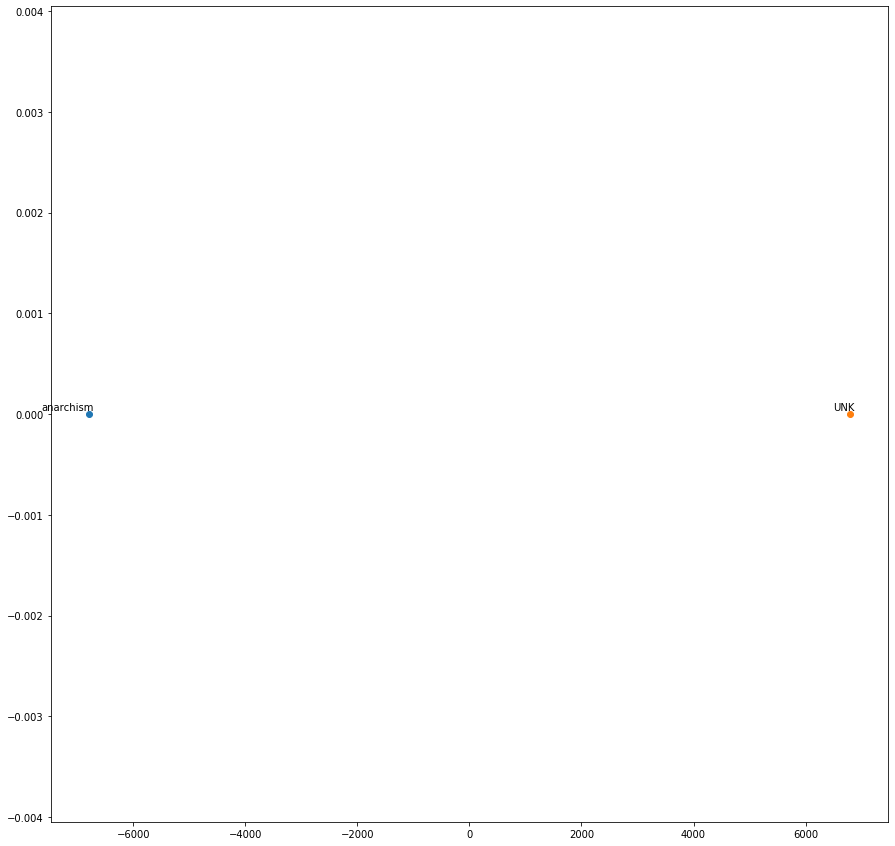

In [17]:
plot_words([1005, 0], embeddings)

In [18]:
indices = np.arange(batcher.vocab_size)
np.random.shuffle(indices)
indices = indices[:1000]
embed_from_indices = model.get_vectors_from_indexes(batcher, indices)
print(embed_from_indices.shape)

(1000, 40)


TSNE calculated...


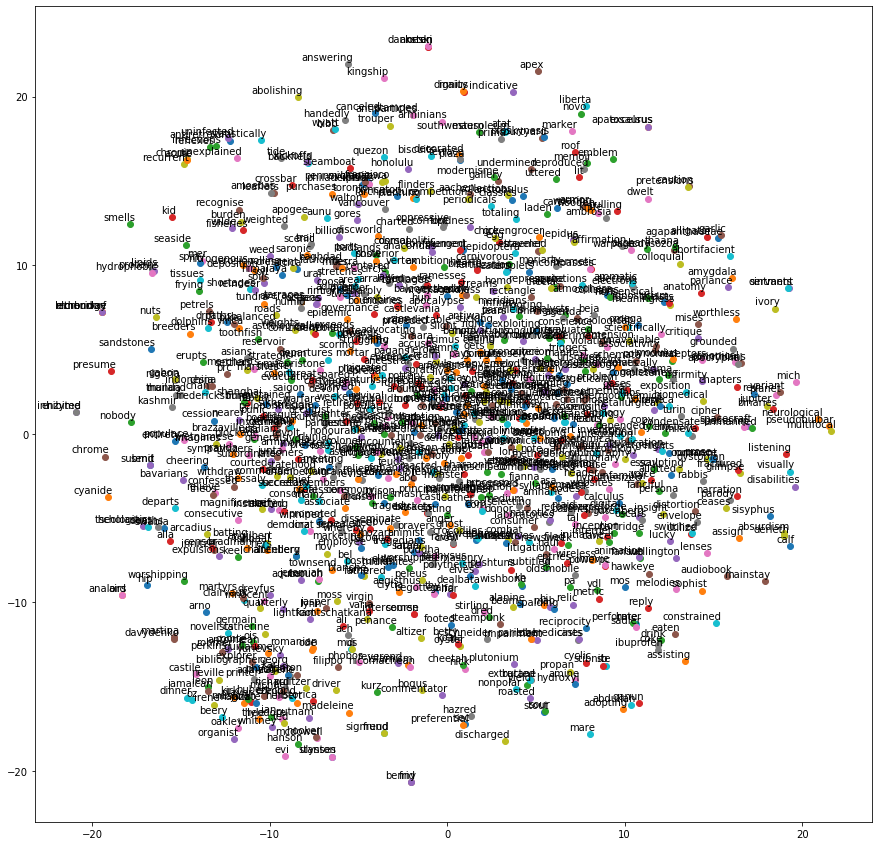

In [19]:
plot_words(indices, embed_from_indices)

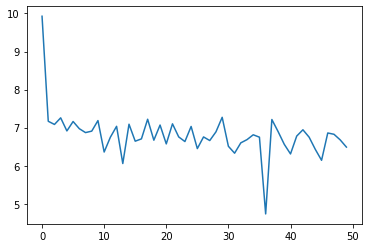

In [20]:
"""plot loss without tensorboard"""
losses = np.load('./logs/losses_history.npy')
plt.plot(losses)
plt.show()

In [21]:
!ls -l

total 128288
drwxr-xr-x 2 root root      4096 Feb 26 22:35 Graph
drwxr-xr-x 2 root root      4096 Feb 26 22:52 logs
drwxr-xr-x 2 root root      4096 Feb 26 22:34 logs_new
drwxr-xr-x 1 root root      4096 Feb  5 18:37 sample_data
-rw-r--r-- 1 root root 100000000 Jun  9  2006 text8
-rw-r--r-- 1 root root  31344016 Jul 23  2009 text8.zip


In [22]:
print(batcher.vocab_size)
embeddings = model.get_vectors_from_indexes(batcher, range(batcher.vocab_size))

20462


In [0]:
"""nearest neighbors, word analogies using gensim"""
def create_file_for_gensim(embeddings, vocab_size, vec_size, filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size) + ' ' + str(vec_size) + '\n')
        for i in range(vocab_size):
            to_write = ' '.join([batcher.index2word[i]] + [str(num) for num in embeddings[i]])
            f.write(to_write + '\n')

create_file_for_gensim(embeddings, embeddings.shape[0], EMBEDDINGS_SIZE, 'word2vec.vec')

In [24]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('word2vec.vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def print_similar(similar_to):
  for similar in w2v.similar_by_word(similar_to)[:20]:
      print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

In [26]:
print_similar('good')

word: what, similarity: 0.76
word: reason, similarity: 0.75
word: how, similarity: 0.75
word: thing, similarity: 0.72
word: always, similarity: 0.72
word: exceedingly, similarity: 0.71
word: true, similarity: 0.70
word: everything, similarity: 0.69
word: interesting, similarity: 0.68
word: nothing, similarity: 0.68


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [27]:
print_similar('dog')

word: eat, similarity: 0.68
word: hood, similarity: 0.66
word: lenin, similarity: 0.66
word: vulture, similarity: 0.65
word: keith, similarity: 0.65
word: jerry, similarity: 0.64
word: octopus, similarity: 0.63
word: nicknamed, similarity: 0.62
word: gershwin, similarity: 0.62
word: vocals, similarity: 0.61


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [28]:
print_similar('king')

word: son, similarity: 0.86
word: prince, similarity: 0.82
word: emperor, similarity: 0.80
word: duke, similarity: 0.80
word: throne, similarity: 0.79
word: queen, similarity: 0.76
word: iv, similarity: 0.76
word: iii, similarity: 0.76
word: daughter, similarity: 0.76
word: sparta, similarity: 0.75


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [29]:
print_similar('queen')

word: king, similarity: 0.76
word: consort, similarity: 0.76
word: prince, similarity: 0.73
word: celebrated, similarity: 0.71
word: netherlands, similarity: 0.70
word: sweden, similarity: 0.69
word: elizabeth, similarity: 0.69
word: princess, similarity: 0.69
word: son, similarity: 0.68
word: iv, similarity: 0.68


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [30]:
print_similar('mother')

word: wife, similarity: 0.87
word: daughter, similarity: 0.80
word: her, similarity: 0.80
word: marriage, similarity: 0.79
word: father, similarity: 0.77
word: death, similarity: 0.77
word: son, similarity: 0.77
word: husband, similarity: 0.77
word: she, similarity: 0.77
word: brother, similarity: 0.76


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [31]:
print_similar('vegetable')

word: leaf, similarity: 0.72
word: vegetables, similarity: 0.72
word: dyes, similarity: 0.70
word: farming, similarity: 0.69
word: fresh, similarity: 0.69
word: nutrients, similarity: 0.69
word: crop, similarity: 0.68
word: flowers, similarity: 0.68
word: animal, similarity: 0.68
word: eggs, similarity: 0.67


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [32]:
print_similar('elephant')

word: hound, similarity: 0.74
word: emu, similarity: 0.74
word: setter, similarity: 0.70
word: elk, similarity: 0.69
word: magnificent, similarity: 0.68
word: phobos, similarity: 0.67
word: leopard, similarity: 0.67
word: marcellinus, similarity: 0.67
word: trainer, similarity: 0.67
word: blue, similarity: 0.66


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [33]:
similar_words = w2v.most_similar(positive=['king', 'woman'], negative=['man'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: emperor, similarity: 0.74
word: besieged, similarity: 0.69
word: daughter, similarity: 0.69
word: throne, similarity: 0.67
word: rufinus, similarity: 0.66
word: commemorating, similarity: 0.66
word: macedonia, similarity: 0.66
word: married, similarity: 0.65
word: son, similarity: 0.65
word: duke, similarity: 0.64


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [34]:
similar_words = w2v.most_similar(positive=['girl', 'father'], negative=['mother'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: boy, similarity: 0.68
word: mamoru, similarity: 0.63
word: popularly, similarity: 0.61
word: binaries, similarity: 0.61
word: begum, similarity: 0.61
word: kim, similarity: 0.61
word: film, similarity: 0.60
word: knight, similarity: 0.60
word: vostok, similarity: 0.60
word: boys, similarity: 0.60


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
"""nearest neighbors, word analogies using my own implemetation"""
"""as it can be seen we got the same results!!!!!!!!!"""
def get_similar_by_word(embeddings, similar_to, num_top=10):
    index = batcher.word2index[similar_to]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        nearby_index = tf.placeholder(tf.int32, shape=(), name='nearby_index')
        nearby_embed = tf.gather(norm_embed, nearby_index)
        nearby_embed = tf.reshape(nearby_embed, (1, -1))
        nearby_dist = tf.matmul(nearby_embed, norm_embed, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, nearby_index : index}
        vals, idxs = model.sess.run([nearby_val, nearby_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten()[1:], words[1:]
      
def get_analogy_by_word(embeddings, positive, negative, num_top=10):
    a = batcher.word2index[negative[0]]
    b = batcher.word2index[positive[0]]
    c = batcher.word2index[positive[1]]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        a_index = tf.placeholder(tf.int32, shape=(), name='a_index')
        b_index = tf.placeholder(tf.int32, shape=(), name='b_index')
        c_index = tf.placeholder(tf.int32, shape=(), name='c_index')
        a_embed = tf.reshape(tf.gather(norm_embed, a_index), (1, -1))
        b_embed = tf.reshape(tf.gather(norm_embed, b_index), (1, -1))
        c_embed = tf.reshape(tf.gather(norm_embed, c_index), (1, -1))
        target_embed = c_embed + b_embed - a_embed
        target_dist = tf.matmul(target_embed, norm_embed, transpose_b=True)
        target_val, target_idx = tf.nn.top_k(target_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, a_index : a, b_index : b, c_index : c}
        vals, idxs = model.sess.run([target_val, target_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten(), words


In [36]:
vals, words = get_similar_by_word(embeddings, 'vegetable')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: leaf, similarity: 0.72
word: vegetables, similarity: 0.72
word: dyes, similarity: 0.70
word: farming, similarity: 0.69
word: fresh, similarity: 0.69
word: nutrients, similarity: 0.69
word: crop, similarity: 0.68
word: flowers, similarity: 0.68
word: animal, similarity: 0.68


In [37]:
vals, words = get_similar_by_word(embeddings, 'queen')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: king, similarity: 0.76
word: consort, similarity: 0.76
word: prince, similarity: 0.73
word: celebrated, similarity: 0.71
word: netherlands, similarity: 0.70
word: sweden, similarity: 0.69
word: elizabeth, similarity: 0.69
word: princess, similarity: 0.69
word: son, similarity: 0.68


In [38]:
vals, words = get_similar_by_word(embeddings, 'elephant')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: hound, similarity: 0.74
word: emu, similarity: 0.74
word: setter, similarity: 0.70
word: elk, similarity: 0.69
word: magnificent, similarity: 0.68
word: phobos, similarity: 0.67
word: leopard, similarity: 0.67
word: marcellinus, similarity: 0.67
word: trainer, similarity: 0.67


In [39]:
vals, words = get_analogy_by_word(embeddings, positive=['girl', 'father'], negative=['mother'])
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: girl, similarity: 0.91
word: boy, similarity: 0.76
word: mamoru, similarity: 0.71
word: father, similarity: 0.70
word: popularly, similarity: 0.69
word: binaries, similarity: 0.69
word: begum, similarity: 0.68
word: kim, similarity: 0.68
word: film, similarity: 0.68
word: knight, similarity: 0.68


In [0]:
np.save('./logs/embeddings', embeddings)

In [0]:
"""download graph and loss to visualize them localy (ngrock is too slow with VPN) """
from google.colab import files
files.download('./logs/embeddings.npy') 

In [43]:
!ls

Graph  logs  logs_new  sample_data  text8  text8.zip  word2vec.vec


In [0]:
"""destructor for the model"""
model.close()